In [2]:
import sys
import rospy
import os
import numpy as np
import cv2
from matplotlib import pyplot as plt
from sensor_msgs.msg import Image
from cv_bridge import CvBridge


# Auxiliar functions

Function to add a colorbar which matches size with the displayed plot

In [3]:
from mpl_toolkits import axes_grid1

def add_colorbar(im, aspect=20, pad_fraction=0.5, **kwargs):
    """Add a vertical color bar to an image plot."""
    divider = axes_grid1.make_axes_locatable(im.axes)
    width = axes_grid1.axes_size.AxesY(im.axes, aspect=1./aspect)
    pad = axes_grid1.axes_size.Fraction(pad_fraction, width)
    current_ax = plt.gca()
    cax = divider.append_axes("right", size=width, pad=pad)
    plt.sca(current_ax)
    return im.axes.figure.colorbar(im, cax=cax, **kwargs)

Function which returns a normalized gaussian kernel

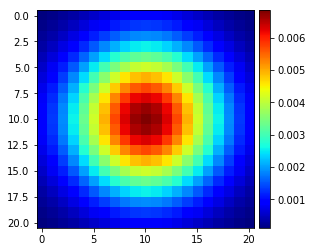

In [4]:
# http://subsurfwiki.org/wiki/Gaussian_filter
def gaussian_kernel(size = 10, size_y=None, sigma = 6):
    size = int(size/2)
    if not size_y:
        size_y = size
    else:
        size_y = int(size_y)
    x, y = np.mgrid[-size:size+1, -size_y:size_y+1]
    g = np.exp(-(x**2/float(2*sigma**2)+y**2/float(2*sigma**2)))
    return g / g.sum()
 
# Make the Gaussian by calling the function
gaussian_kernel_array = gaussian_kernel(size = 20, sigma = 5)
 
im = plt.imshow(gaussian_kernel_array, cmap=plt.get_cmap('jet'), interpolation='nearest')
add_colorbar(im)
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

Draw a surface plot from a 2D matrix

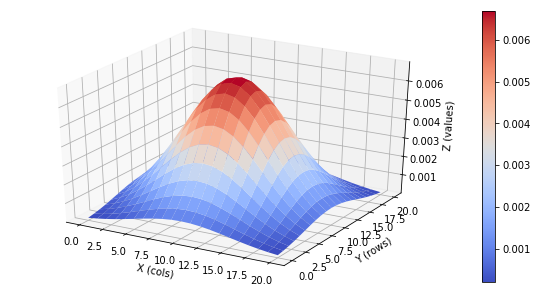

In [5]:
from mpl_toolkits.mplot3d import Axes3D

def surface_plot (matrix, **kwargs):
    # acquire the cartesian coordinate matrices from the matrix
    # x is cols, y is rows
    (x, y) = np.meshgrid(np.arange(matrix.shape[0]), np.arange(matrix.shape[1]))
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(x, y, matrix, **kwargs)
    return (fig, ax, surf)


# m.shape must be (10,10)

(fig, ax, surf) = surface_plot(gaussian_kernel_array, cmap=plt.cm.coolwarm)

fig.colorbar(surf)

ax.set_xlabel('X (cols)')
ax.set_ylabel('Y (rows)')
ax.set_zlabel('Z (values)')

plt.show()

Slide a window of a given size, with a given step size, across a 2D Matrix.

In [6]:
def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

# Read RGB and depth image

In [7]:
rgbimg = cv2.imread('rgb.jpg')
rgbimg = cv2.cvtColor(rgbimg, cv2.COLOR_RGB2BGR)
depthimg = cv2.imread('depth.jpg',0)

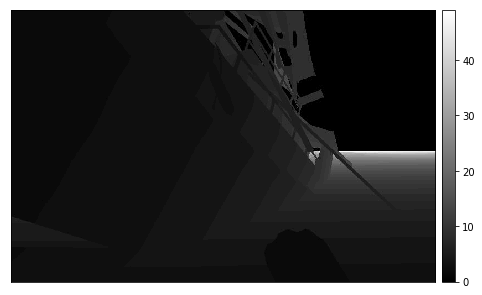

In [8]:
im = plt.imshow(depthimg, cmap='gray');
add_colorbar(im)
plt.rcParams['figure.figsize'] = [10, 5]
plt.xticks([]), plt.yticks([]);

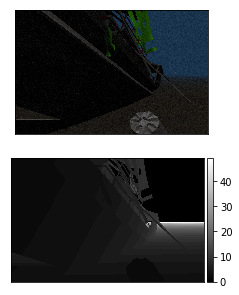

In [9]:
plt.subplot(211),plt.imshow(rgbimg)
plt.xticks([]), plt.yticks([])

plt.subplot(212)
im = plt.imshow(depthimg, cmap = 'gray')
add_colorbar(im)

plt.rcParams['figure.figsize'] = [40, 20]
plt.xticks([]), plt.yticks([])
plt.show()

# Gaussian blurring with distance

First, we test a simple gaussian blurring that linearly increases with distance

In [10]:
# define the window width and height
gauss_clone = rgbimg.copy()
gauss_image = np.zeros((rgbimg.shape[0],rgbimg.shape[1]), np.float32)
(winW, winH) = (21, 21)
print(np.amax(depthimg))

for (x, y, window) in sliding_window(gauss_clone, stepSize=17, windowSize=(winW, winH)):
	# if the window does not meet our desired window size, ignore it
	if window.shape[0] != winH or window.shape[1] != winW:
		continue

	sig = np.mean(depthimg[y:y + winW, x:x + winH])
	if sig <= 0:
		sig = 100
    
	
	#gauss_clone[y:y + winW, x:x + winH] = cv2.GaussianBlur(window,(winW, winH), int(sig))
	kernel = gaussian_kernel(size = winW, sigma = sig)
	gauss_image[y:y + winW, x:x + winH] = gauss_image[y:y + winW, x:x + winH] + kernel
	gauss_clone[y:y + winW, x:x + winH] = cv2.filter2D(gauss_clone[y:y + winW, x:x + winH],-1,kernel)
	

	# since we do not have a classifier, we'll just draw the window
	#gauss_clone = rgbimg.copy()
	#cv2.rectangle(gauss_clone, (x, y), (x + winW, y + winH), (0, 255, 0), 2)
	#cv2.imshow("Window", gauss_clone)
	#cv2.waitKey(1)

49


Distances measured at different parts of the image

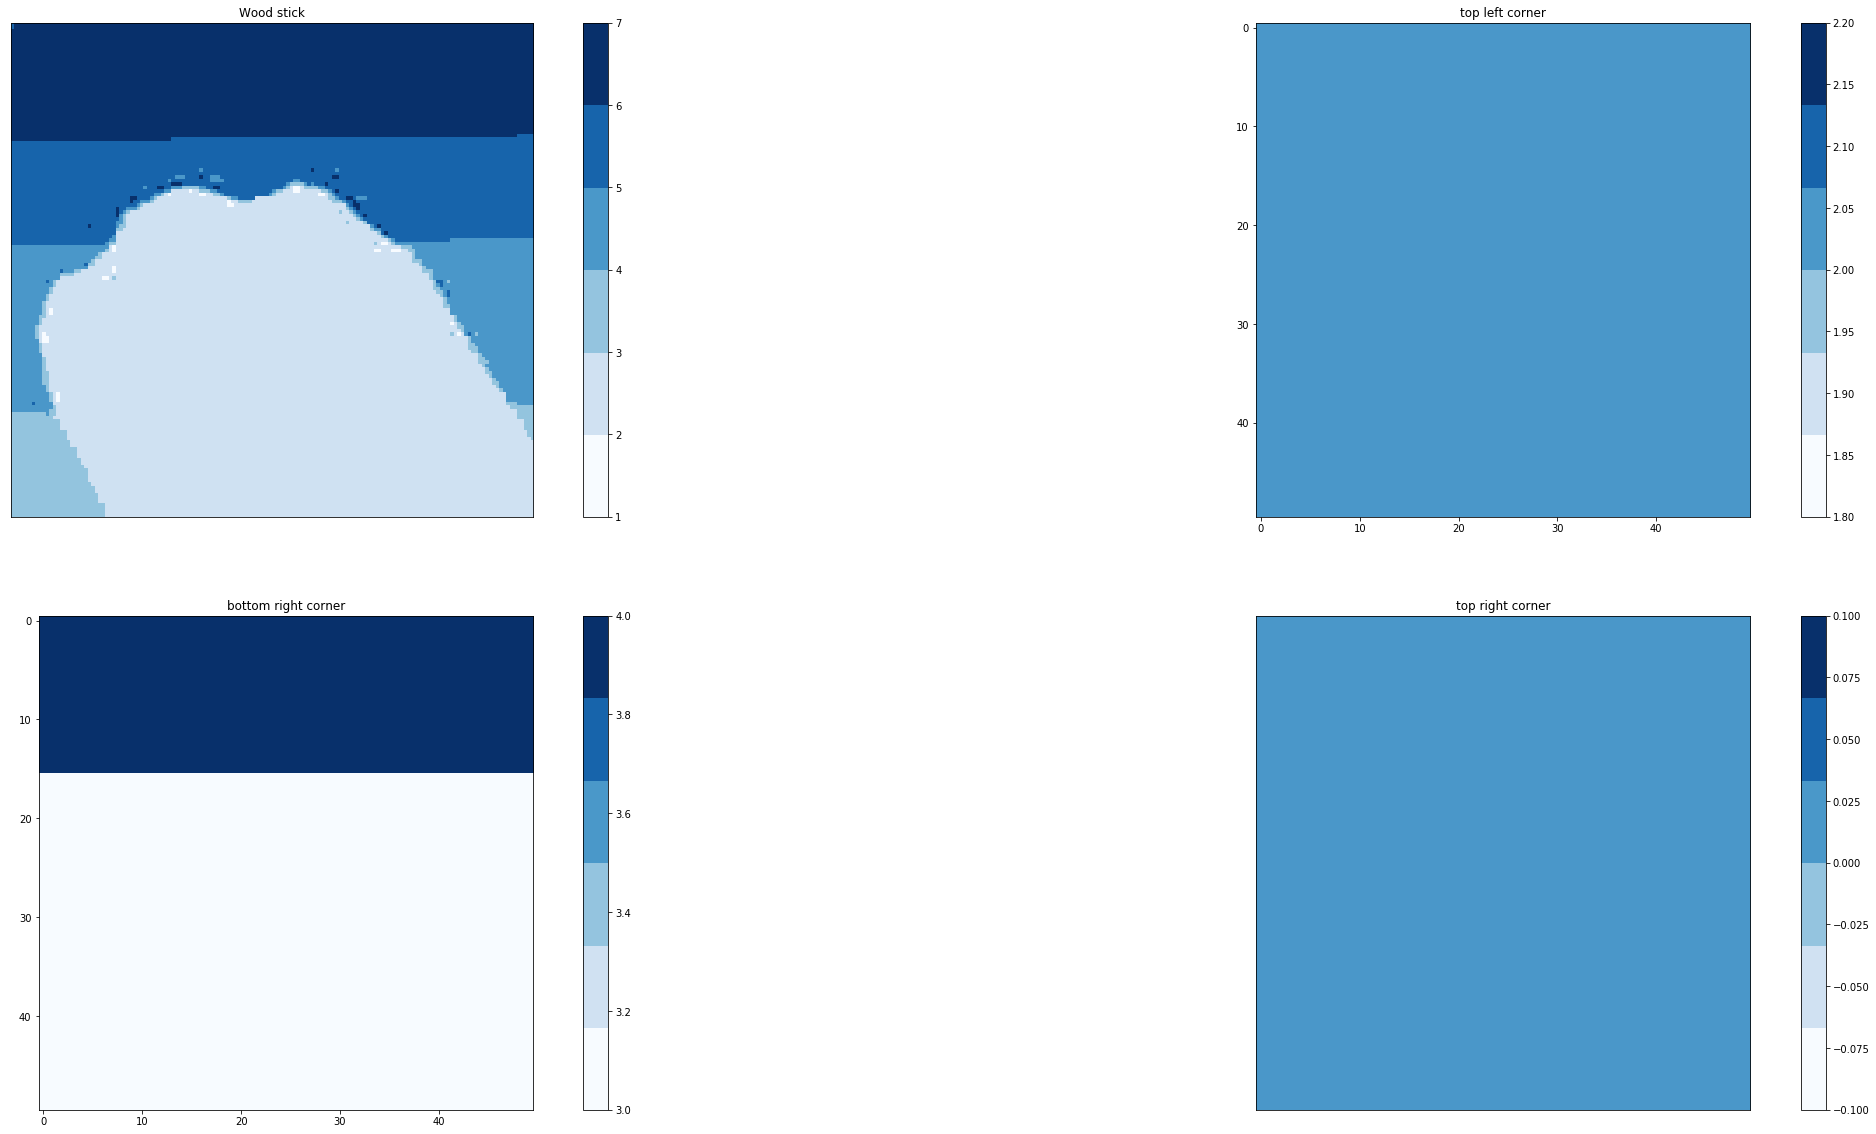

In [11]:
plt.subplot(221),plt.imshow(depthimg[350:492, 450:600], cmap=plt.cm.get_cmap('Blues', 6)),plt.title('Wood stick')
plt.xticks([]), plt.yticks([]),plt.colorbar()

plt.subplot(222),plt.imshow(depthimg[0:50, 0:50], cmap=plt.cm.get_cmap('Blues', 6))
plt.title('top left corner'),plt.colorbar()

plt.subplot(223),plt.imshow(depthimg[442:492, 718:768], cmap=plt.cm.get_cmap('Blues', 6))
plt.title('bottom right corner'),plt.colorbar()

plt.subplot(224),plt.imshow(depthimg[0:50, -100:-50], cmap=plt.cm.get_cmap('Blues', 6))
plt.title('top right corner'),plt.colorbar()

plt.xticks([]), plt.yticks([])
plt.rcParams['figure.figsize'] = [20, 10]
plt.show()

Resulting kernel shape at the given parts of the image

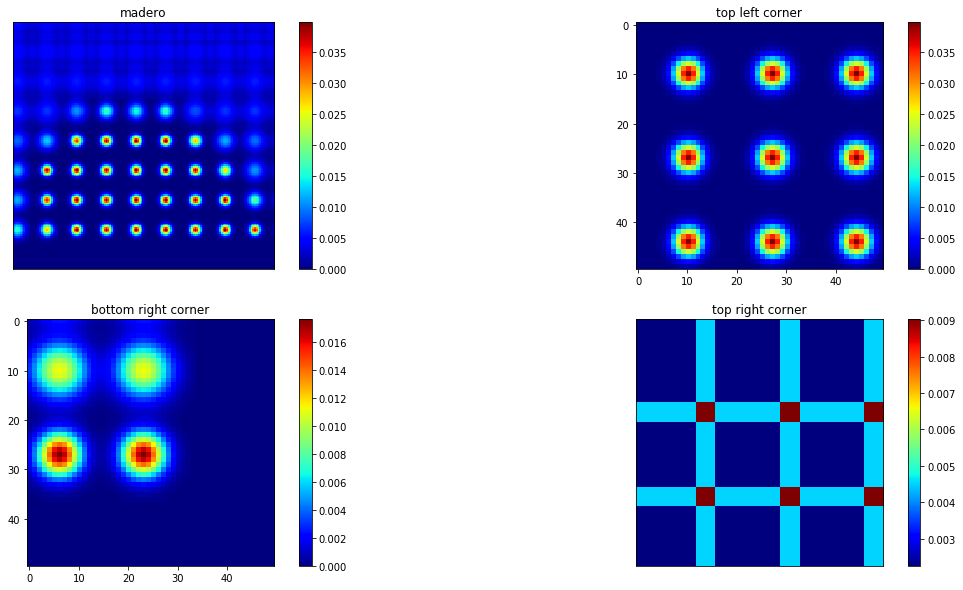

In [12]:
plt.subplot(221),plt.imshow(gauss_image[350:492, 450:600], cmap=plt.get_cmap('jet'), interpolation='nearest')
plt.title('madero')
plt.xticks([]), plt.yticks([]),plt.colorbar()

plt.subplot(222),plt.imshow(gauss_image[0:50, 0:50], cmap=plt.get_cmap('jet'), interpolation='nearest')
plt.title('top left corner'),plt.colorbar()

plt.subplot(223),plt.imshow(gauss_image[442:492, 718:768], cmap=plt.get_cmap('jet'), interpolation='nearest')
plt.title('bottom right corner'),plt.colorbar()

plt.subplot(224),plt.imshow(gauss_image[0:50, -100:-50], cmap=plt.get_cmap('jet'), interpolation='nearest')
plt.title('top right corner')

plt.xticks([]), plt.yticks([]),plt.colorbar()
plt.show()

Resulting image vs Original image

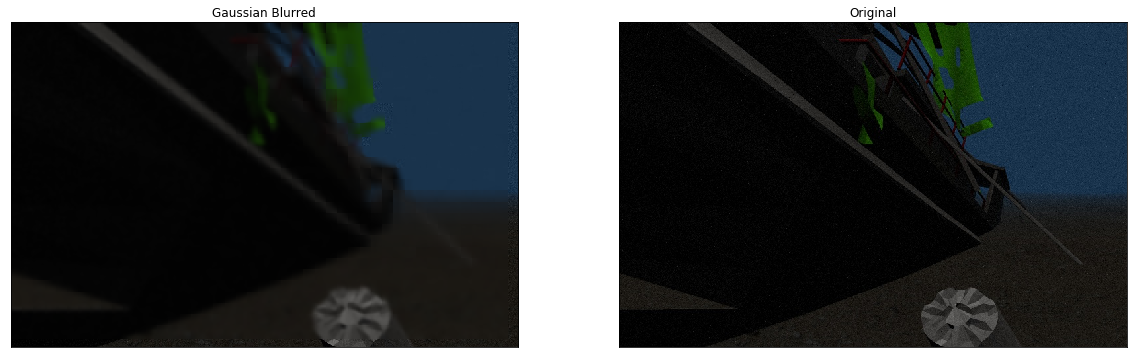

In [13]:
plt.subplot(121),plt.imshow(gauss_clone),plt.title('Gaussian Blurred')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(rgbimg),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.show()

# Point Spread Function

We define the point spread function, which considers the redistribution of power in presence of scattering and absorption. A greater absorption decreases the energy in the point spread function, while a greater scattering implies a larger size of point spreading.
This can be expressed as a convolution integral:

$I_2(x,y) = I_1(x_p,y_p) * S(x,y,z')$

Here we define a custom kernel for the Point Spread Function and test it at different depths

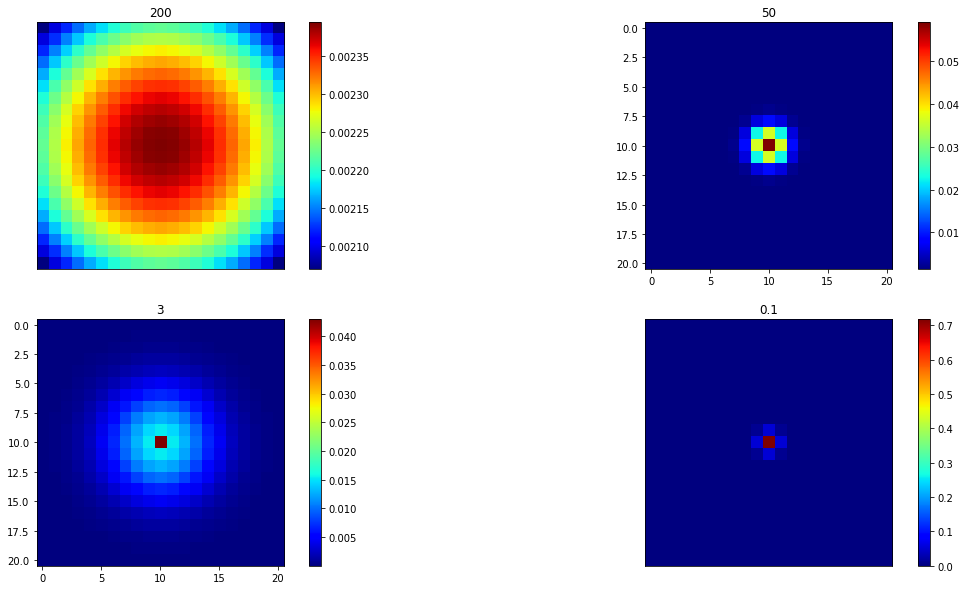

In [14]:
def PSF_kernel(size = 10, size_y=None, sigma = 6, depth = 0):
    size = int(size/2)
    center = size/10
    if not size_y:
        size_y = size
    else:
        size_y = int(size_y)
    x, y = np.mgrid[-size:size+1, -size_y:size_y+1]
    g = np.exp(-((x)**2/float(2*(sigma+0.1)**2)+(y)**2/float(2*(sigma+0.1)**2)))/(2*np.pi*(sigma+0.1)**2)+np.exp(-((x)**2/float(2*(0.1*depth)**2)+(y)**2/float(2*(0.1*depth)**2)))/(2*np.pi*(0.8*depth)**2)
    return g / g.sum()
 
# Make the Gaussian by calling the function
PSF_kernel_array = PSF_kernel(size = 20, sigma = 200, depth = 200)
 
plt.subplot(221),plt.imshow(PSF_kernel_array, cmap=plt.get_cmap('jet'), interpolation='nearest')
plt.title('200')
plt.xticks([]), plt.yticks([]),plt.colorbar()

PSF_kernel_array = PSF_kernel(size = 20, sigma = 50, depth = 10)

plt.subplot(222),plt.imshow(PSF_kernel_array, cmap=plt.get_cmap('jet'), interpolation='nearest')
plt.title('50'),plt.colorbar()

PSF_kernel_array = PSF_kernel(size = 20, sigma = 3, depth = 3)

plt.subplot(223),plt.imshow(PSF_kernel_array, cmap=plt.get_cmap('jet'), interpolation='nearest')
plt.title('3'),plt.colorbar()

PSF_kernel_array = PSF_kernel(size = 20, sigma = 0.5, depth = 0.5)

plt.subplot(224),plt.imshow(PSF_kernel_array, cmap=plt.get_cmap('jet'), interpolation='nearest')
plt.title('0.1')

plt.xticks([]), plt.yticks([]),plt.colorbar()
plt.show()

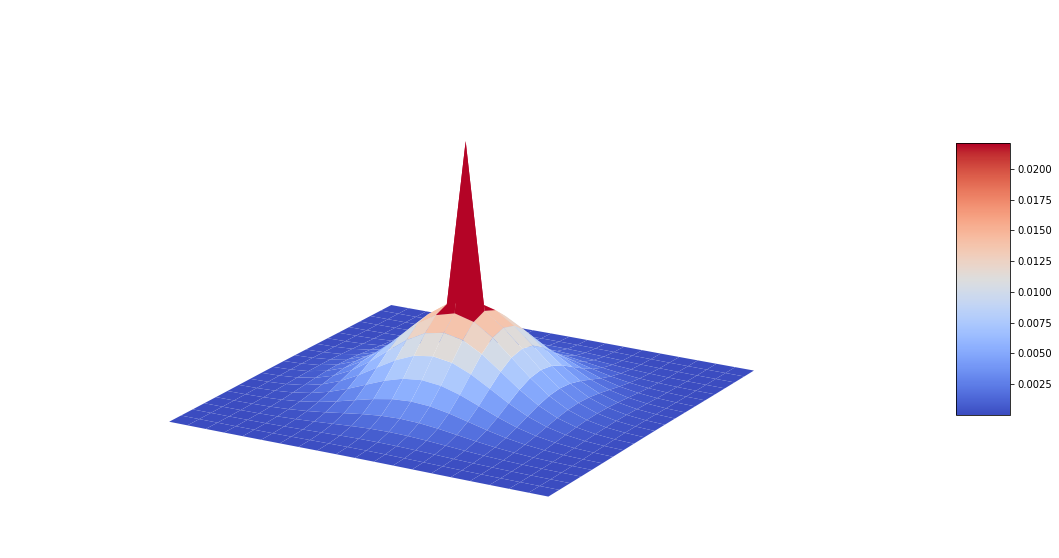

In [15]:
(fig, ax, surf) = surface_plot(PSF_kernel(size = 20, sigma = 3, depth = 3), cmap=plt.cm.coolwarm)

fig.colorbar(surf, shrink=0.5 ,aspect = 5 )
#ax.set_xlabel('X (cols)')
#ax.set_ylabel('Y (rows)')
#ax.set_zlabel('Z (values)')

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.xaxis.pane.set_edgecolor('w')
ax.yaxis.pane.set_edgecolor('w')
ax.zaxis.pane.set_edgecolor('w')
ax.set_axis_off() 

plt.xticks([]), plt.yticks([]),ax.set_zticks([]);
plt.rcParams['figure.figsize'] = [8, 5]
plt.show()

### With the custom kernel

In [16]:
# define the window width and height
direct_clone = rgbimg.copy()
depthcorrected = np.where(depthimg!=0, depthimg, 200)
(winW, winH) = (17, 17)

for (x, y, window) in sliding_window(direct_clone, stepSize=7, windowSize=(winW, winH)):
    # if the window does not meet our desired window size, ignore it
    if window.shape[0] != winH or window.shape[1] != winW:
        continue

    #sig = np.exp(-0.2*depthcorrectede[y:y + winW, x:x + winH])
    sig = PSF_kernel(size = winW, 
                     sigma = depthcorrected[int(y+winW/2),int(x+winH/2)],
                     depth = depthcorrected[int(y+winW/2),int(x+winH/2)])#+np.exp(-6.9*depthcorrected[y:y + winW, x:x + winH])

    direct_clone[y:y + winW, x:x + winH] = cv2.filter2D(rgbimg[y:y + winW, x:x + winH],-1,sig)


### With the gauss kernel

(492, 768, 3)


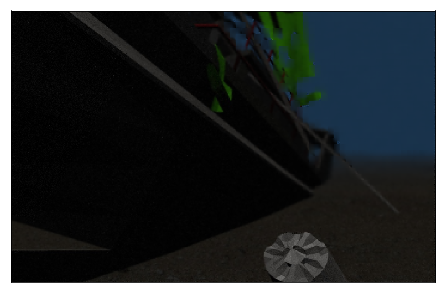

In [17]:
# define the window width and height
gauss_clone  = rgbimg.copy()
depthcorrected = np.where(depthimg!=0, depthimg, 200)
(winW, winH) = (17, 17)
print(gauss_clone.shape)

for (x, y, window) in sliding_window(gauss_clone, stepSize=11, windowSize=(winW, winH)):
    # if the window does not meet our desired window size, ignore it
    if window.shape[0] != winH or window.shape[1] != winW:
        continue

    #gauss_clone[y:y + winW, x:x + winH]  = cv2.GaussianBlur(gauss_clone[y:y + winW, x:x + winH],
                                                            #(winW, winH),
                                                            #0.1*depthcorrected[int(y+winW/2),int(x+winH/2)])
    gauss_clone[y:y + winW, x:x + winH]  = cv2.GaussianBlur(gauss_clone[y:y + winW, x:x + winH],
                                                            (winW, winH),
                                                            0.2*depthcorrected[int(y+winW/2),int(x+winH/2)])
plt.imshow(gauss_clone);
plt.xticks([]), plt.yticks([]);

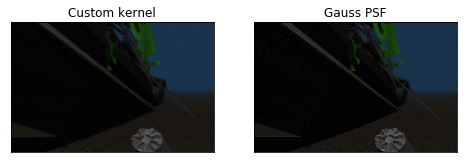

In [18]:
#clone = rgbimg.copy()
#dst = cv2.filter2D(clone,-1,gauss_image)
plt.subplot(121),plt.imshow(direct_clone),plt.title('Custom kernel')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(gauss_clone),plt.title('Gauss PSF')
plt.xticks([]), plt.yticks([])
plt.show()

# Style transfer of image

In [19]:
from torchvision import transforms
from transformer_net import TransformerNet
import torch
import re

stylized  = gauss_clone.copy()
content_transform = transforms.Compose([
                            transforms.ToTensor(),
                            transforms.Lambda(lambda x: x.mul(255))
                            ])

content_image = content_transform(stylized)
content_image = content_image.unsqueeze(0).to('cpu')


with torch.no_grad():
            style_model = TransformerNet()
            state_dict = torch.load('../models/uw_turbid.model')
            # remove saved deprecated running_* keys in InstanceNorm from the checkpoint
            for k in list(state_dict.keys()):
                if re.search(r'in\d+\.running_(mean|var)$', k):
                    del state_dict[k]
            style_model.load_state_dict(state_dict)
            style_model.to('cpu')

            output = style_model(content_image).cpu()
            img = output[0].clone().clamp(0, 255).numpy()
            img = img.transpose(1, 2, 0).astype("uint8")
            #img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

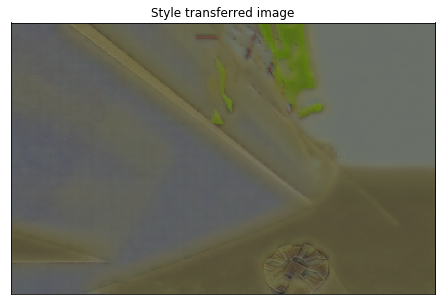

In [20]:
plt.imshow(img);
plt.xticks([]), plt.yticks([])
plt.title("Style transferred image");

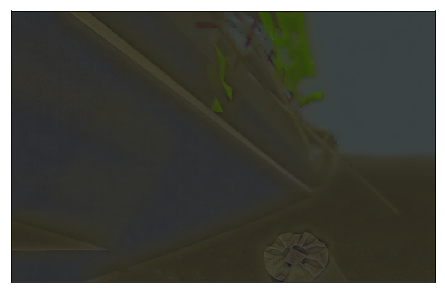

In [21]:
res = cv2.addWeighted(img,0.5,gauss_clone,0.2,0)
plt.imshow(res);
plt.xticks([]), plt.yticks([]);

# Separate image according to depth values

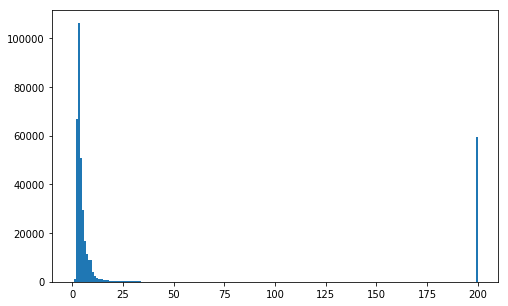

In [22]:
values, bins, patchs = plt.hist(depthcorrected.ravel(),200,[0,200])
plt.show()

Separate rgb image according to depth

In [23]:
mask = [cv2.threshold(depthcorrected, Z, np.amax(bins), cv2.THRESH_BINARY_INV) for Z in bins]

In [24]:
mask2 = [cv2.bitwise_xor(mask[i][1],mask[i-1][1]) for i in range(len(mask))]

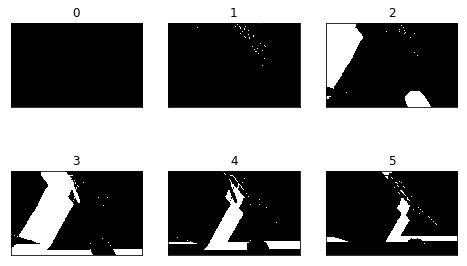

In [25]:
plt.subplot(231),plt.imshow(mask2[0], cmap = 'gray'),plt.title('0')
plt.xticks([]), plt.yticks([])

plt.subplot(232),plt.imshow(mask2[1],cmap = 'gray'),plt.title('1')
plt.xticks([]), plt.yticks([])

plt.subplot(233),plt.imshow(mask2[2],cmap = 'gray'),plt.title('2')
plt.xticks([]), plt.yticks([])

plt.subplot(234),plt.imshow(mask2[3],cmap = 'gray'),plt.title('3')
plt.xticks([]), plt.yticks([])

plt.subplot(235),plt.imshow(mask2[4],cmap = 'gray'),plt.title('4')
plt.xticks([]), plt.yticks([])

plt.subplot(236),plt.imshow(mask2[5],cmap = 'gray'),plt.title('5')
plt.xticks([]), plt.yticks([])

#plt.rcParams['figure.figsize'] = [20, 10]
plt.show()

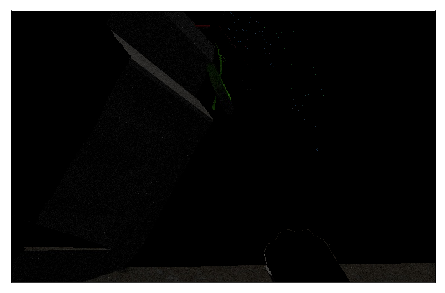

In [26]:
gauss_clone  = rgbimg.copy()
maskE = [cv2.bitwise_and(src1 = gauss_clone,src2 = gauss_clone,mask = np.asarray(mask2[i]))
         for i in range(len(mask))]
plt.imshow(maskE[3]);
plt.xticks([]), plt.yticks([]);
plt.rcParams['figure.figsize'] = [20, 10]

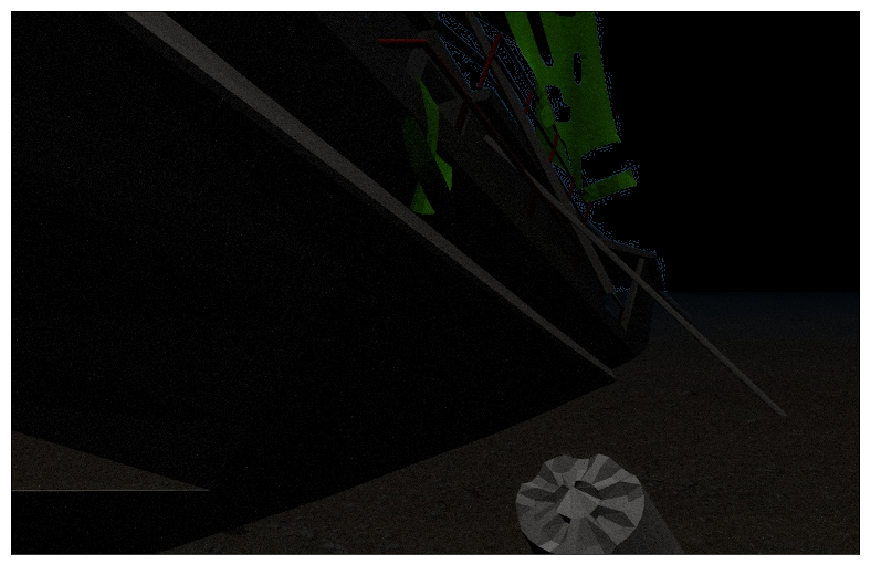

In [27]:
maskd = [np.uint8(maskE[i]*np.exp(-0.05*bins[i]))
         for i in range(len(bins))]
final = sum(maskd[1:201])
plt.imshow(final);
plt.xticks([]), plt.yticks([]);
plt.rcParams['figure.figsize'] = [20, 10]

In [28]:
%%timeit
mask =  [cv2.threshold(depthcorrected, Z, np.amax(bins), cv2.THRESH_BINARY_INV) for Z in bins]
maskd = [np.uint8(cv2.bitwise_and(src1 = gauss_clone,src2 = gauss_clone,
                                  mask = np.asarray(cv2.bitwise_xor(mask[i][1],mask[i-1][1])))*
                  np.exp(-0.05*bins[i]))
         for i in range(len(bins))]

740 ms ± 15.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [29]:
%%timeit
mask =  [cv2.threshold(depthcorrected, Z, np.amax(bins), cv2.THRESH_BINARY_INV) for Z in bins]
mask2 = [cv2.bitwise_xor(mask[i][1],mask[i-1][1]) for i in range(len(mask))]
maskE = [cv2.bitwise_and(src1 = gauss_clone,src2 = gauss_clone,mask = np.asarray(mask2[i]))
         for i in range(len(mask))]
maskd = [np.uint8(maskE[i]*np.exp(-0.05*bins[i]))
         for i in range(len(bins))]

801 ms ± 2.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Add artificial light's haze

based on code seen in https://github.com/UjjwalSaxena/Automold--Road-Augmentation-Library/blob/master/Usage%20Guide.ipynb

In [155]:
import random
import math
def flare_source(image, point,radius,src_color):
    overlay= image.copy()
    output= image.copy()
    num_times=radius//10
    alpha= np.linspace(0.0,1,num= num_times)
    rad= np.linspace(1,radius, num=num_times)
    for i in range(num_times):
        cv2.circle(overlay,point, int(rad[i]), src_color, -1)
        alp=alpha[num_times-i-1]*alpha[num_times-i-1]*alpha[num_times-i-1]
        cv2.addWeighted(overlay, alp, output, 1 -alp ,0, output)
    return output

def add_sun_flare_line(flare_center,angle,imshape):
    x=[]
    y=[]
    i=0
    for rand_x in range(0,imshape[1],10):
        rand_y= math.tan(angle)*(rand_x-flare_center[0])+flare_center[1]
        x.append(rand_x)
        y.append(2*flare_center[1]-rand_y)
    return x,y

def add_sun_process(image, no_of_flare_circles,flare_center,radius,x,y,src_color):
    overlay= image.copy()
    output= image.copy()
    imshape=image.shape
    for i in range(no_of_flare_circles):
        alpha=random.uniform(0.05,0.2)
        r=random.randint(0, len(x)-1)
        rad=random.randint(1, imshape[0]//100-2)
        cv2.circle(overlay,(int(x[r]),int(y[r])), rad*rad*rad, (random.randint(max(src_color[0]-50,0), src_color[0]),random.randint(max(src_color[1]-50,0), src_color[1]),random.randint(max(src_color[2]-50,0), src_color[2])), -1)
        cv2.addWeighted(overlay, alpha, output, 1 - alpha,0, output)                      
    output= flare_source(output,(int(flare_center[0]),int(flare_center[1])),radius,src_color)
    return output

def add_sun_flare(image,flare_center=-1, angle=-1, no_of_circles=8,radius=400, src_color=(255,255,255)):
    """ Adding light flare
    :param image: image
    :param flare_center: center of light in coordinates (x,y)
    :param angle: angle of flare, default random
    :param no_of_circles: number of secondary circles
    :param radius: radius of flare
    :param src_color: color of flare, default white
    
    Returns flared image"""
    image_RGB=[]
    if(angle!=-1):
        angle=angle%(2*math.pi)
    if not(no_of_circles>=0 and no_of_circles<=20):
        raise Exception(err_flare_circle_count)

    imshape=image.shape
    if(angle==-1):
        angle_t=random.uniform(0,2*math.pi)
        if angle_t==math.pi/2:
            angle_t=0
    else:
        angle_t=angle
        
    if flare_center==-1:
        flare_center_t=(random.randint(0,imshape[1]),random.randint(0,imshape[0]//2))
    else:
        flare_center_t=flare_center
    x,y= add_sun_flare_line(flare_center_t,angle_t,imshape)
    output= add_sun_process(image, no_of_circles,flare_center_t,radius,x,y,src_color)
    image_RGB = output
    return image_RGB

err_speed_coeff="Speed coeff can only be between 0 and 1"

In [93]:
import random
import math

def gaussian_flare(size = 10, sigma = 6):
    size = int(size/2)
    x, y = np.mgrid[-size:size+1, -size:size+1]
    g = np.exp(-(x**2/float(2*sigma**2)+y**2/float(2*sigma**2)))
    g = g / g.sum()
    return np.interp(g, (g.min(), g.max()), (0, 255))

def flare_source(image, point,radius,src_color):
    overlay= image.copy()
    output= image.copy()
    num_times=radius//10
    alpha= np.linspace(0.0,1,num= num_times)
    rad= np.linspace(1,radius, num=num_times)
    for i in range(num_times):
        cv2.circle(overlay,point, int(rad[i]), src_color, -1)
        alp=alpha[num_times-i-1]*alpha[num_times-i-1]*alpha[num_times-i-1]
        cv2.addWeighted(overlay, alp, output, 1 -alp ,0, output)
    return output

def add_sun_flare_line(flare_center,angle,imshape):
    x=[]
    y=[]
    i=0
    for rand_x in range(0,imshape[1],10):
        rand_y= math.tan(angle)*(rand_x-flare_center[0])+flare_center[1]
        x.append(rand_x)
        y.append(2*flare_center[1]-rand_y)
    return x,y

def add_sun_process(image, no_of_flare_circles,flare_center,radius,x,y,src_color):
    overlay= image.copy()
    output= image.copy()
    imshape=image.shape
    for i in range(no_of_flare_circles):
        alpha=random.uniform(0.05,0.2)
        r=random.randint(0, len(x)-1)
        rad=random.randint(1, imshape[0]//100-2)
        cv2.circle(overlay,(int(x[r]),int(y[r])), rad*rad*rad, (random.randint(max(src_color[0]-50,0), src_color[0]),random.randint(max(src_color[1]-50,0), src_color[1]),random.randint(max(src_color[2]-50,0), src_color[2])), -1)
        cv2.addWeighted(overlay, alpha, output, 1 - alpha,0, output)                      
    output= flare_source(output,(int(flare_center[0]),int(flare_center[1])),radius,src_color)
    return output

def add_sun_flare(image,flare_center=-1, angle=-1, no_of_circles=8,radius=400, src_color=(255,255,255)):
    """ Adding light flare
    :param image: image
    :param flare_center: center of light in coordinates (x,y)
    :param angle: angle of flare, default random
    :param no_of_circles: number of secondary circles
    :param radius: radius of flare
    :param src_color: color of flare, default white
    
    Returns flared image"""
    image_RGB=[]
    if(angle!=-1):
        angle=angle%(2*math.pi)
    if not(no_of_circles>=0 and no_of_circles<=20):
        raise Exception(err_flare_circle_count)

    imshape=image.shape
    if(angle==-1):
        angle_t=random.uniform(0,2*math.pi)
        if angle_t==math.pi/2:
            angle_t=0
    else:
        angle_t=angle
        
    if flare_center==-1:
        flare_center_t=(random.randint(0,imshape[1]),random.randint(0,imshape[0]//2))
    else:
        flare_center_t=flare_center
    x,y= add_sun_flare_line(flare_center_t,angle_t,imshape)
    output= add_sun_process(image, no_of_circles,flare_center_t,radius,x,y,src_color)
    image_RGB = output
    return image_RGB

(20, 20, 4)


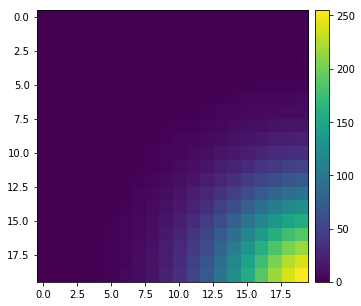

In [219]:
def gaussian_flare(shape = (10,10), size_y=None, center = (0,0), radius = 5, rgb = (255,255,255)):
    size = int(shape[0]/2)
    size_y=int(shape[1]/2)
    sigma = radius
    
    # generate rgb array with light color
    rgbimg = np.ones((shape[0],shape[1],1),dtype = np.uint8)

    # generate the alpha channel 
    x, y = np.mgrid[-size:size, -size_y:size_y]
    x = x - center[0]
    y = y - center[1]
    
    g = np.exp(-(x**2/float(2*sigma**2)+y**2/float(2*sigma**2)))
    g = g / g.sum()
    alpha_channel = np.interp(g, (g.min(), g.max()), (0, 255)).astype(np.uint8)
    
    
    return cv2.merge((rgbimg*rgb[0], rgbimg*rgb[1],rgbimg*rgb[2], alpha_channel))
 
# Make the Gaussian by calling the function
gaussian_kernel_array = gaussian_flare(shape = (20,20), center = (10,10))
print(gaussian_kernel_array.shape)
 
im = plt.imshow(gaussian_kernel_array[:,:,3], interpolation='nearest')
add_colorbar(im)
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

In [236]:
def flare_source(image, point,radius,src_color):
    overlay= image.copy()
    output= image.copy()
    num_times=radius//10
    alpha= np.linspace(0.0,1,num= num_times)
    rad= np.linspace(1,radius, num=num_times)
    for i in range(num_times):
        cv2.circle(overlay,point, int(rad[i]), src_color, -1)
        alp=alpha[num_times-i-1]*alpha[num_times-i-1]*alpha[num_times-i-1]
        cv2.addWeighted(overlay, alp, output, 1 -alp ,0, output)
    return output

(492, 768)

In [244]:
for channel in tal:
    print (channel.shape)

(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(768, 3)
(

In [243]:
clone = res.copy()
light1_pose = (400,400)
flare = gaussian_flare(shape = clone.shape ,center = light1_pose, radius = 200).astype(float)

tal = clone.astype(float)

# Normalize the alpha mask to keep intensity between 0 and 1
alpha = flare[:,:,3]/255

# Multiply the foreground with the alpha matte
foreground = cv2.multiply(alpha, flare[:,:,0])

# Multiply the background with ( 1 - alpha )
#background = cv2.multiply(1.0 - alpha, tal[:,:,0])
background = [cv2.multiply(1.0 - alpha, channel) for channel in tal]

# Add the masked foreground and background.
outImage = cv2.add(foreground, background)


out = cv2.merge((outImage,tal[:,:,1],tal[:,:,2])).astype(np.uint8)
out = cv2.cvtColor(out, cv2.COLOR_YCrCb2BGR)

#alp = 0.5
#wde=cv2.addWeighted(flare, alp, tal, 1 -alp ,0)
im = plt.imshow(out)
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()

error: OpenCV(4.0.0) /home/olaya/opencv/modules/core/src/arithm.cpp:663: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


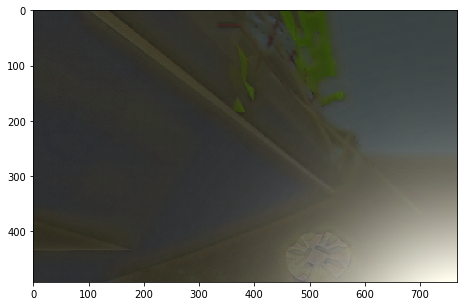

In [240]:
clone = res.copy()
light1_pose = (400,400)
flare = gaussian_flare(shape = clone.shape ,center = light1_pose, radius = 200).astype(float)

tal = cv2.cvtColor(clone, cv2.COLOR_BGR2YCrCb).astype(float)

# Normalize the alpha mask to keep intensity between 0 and 1
alpha = flare[:,:,3]/255

# Multiply the foreground with the alpha matte
foreground = cv2.multiply(alpha, flare[:,:,0])

# Multiply the background with ( 1 - alpha )
background = cv2.multiply(1.0 - alpha, tal[:,:,0])

# Add the masked foreground and background.
outImage = cv2.add(foreground, background)

out = cv2.merge((outImage,tal[:,:,1],tal[:,:,2])).astype(np.uint8)
out = cv2.cvtColor(out, cv2.COLOR_YCrCb2BGR)

#alp = 0.5
#wde=cv2.addWeighted(flare, alp, tal, 1 -alp ,0)
im = plt.imshow(out)
plt.rcParams['figure.figsize'] = [10, 5]
plt.show()


In [147]:
clone = res.copy()
tal = cv2.cvtColor(clone, cv2.COLOR_BGR2YCrCb)[:,:,0]
overlay = cv2.cvtColor(clone, cv2.COLOR_BGR2YCrCb)[:,:,0]
alp = 0.5
radius = 400
flare = gaussian_flare(size = radius, sigma = radius/2)


light1_pose = (tal.shape[1],tal.shape[0])


window = yield(overlay[light1_pose[0]-radius/2:light1_pose[0]+radius/2,
                light1_pose[1]-radius/2:light1_pose[1]+radius/2])

def overlight(img):[0:492,0:768]
    
    
    yield(overlay[light1_pose[0]-radius/2:light1_pose[0]+radius/2,
          light1_pose[1]-radius/2:light1_pose[1]+radius/2])


#wde=cv2.addWeighted(flare, alp, tal, 1 -alp ,0)
#im = plt.imshow(wde)
#plt.rcParams['figure.figsize'] = [10, 5]
#plt.show()

SyntaxError: 'yield' outside function (<ipython-input-147-703f2ae4924c>, line 12)

In [89]:
%%timeit
light1_pose = (res.shape[1],res.shape[0])
light2_pose = (0,res.shape[0])
hazed = add_sun_flare(res  , flare_center = light1_pose)
hazed = add_sun_flare(hazed, flare_center = light2_pose)

35.6 ms ± 1.21 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


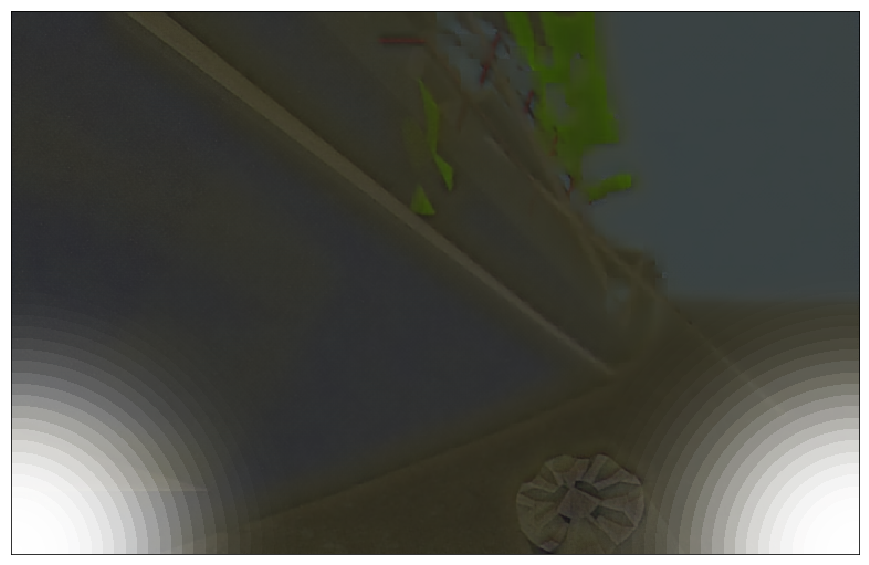

In [158]:
light1_pose = (res.shape[1],res.shape[0])
light2_pose = (0,res.shape[0])
hazed = add_sun_flare(res  , flare_center = light1_pose, radius = 300)
hazed = add_sun_flare(hazed, flare_center = light2_pose, radius = 300)
plt.imshow(hazed);
plt.xticks([]), plt.yticks([]);
plt.rcParams['figure.figsize'] = [20, 10]